In [11]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg
import scipy.optimize as op

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
# add NFW with same mass
h0 = 0.7
Om0 = 0.3
z_max = 40./h0
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100*h0, Om0=Om0)
from astropy import units as u

def mass_richness_sv(richness,z):
    #From SV paper
    M_0 = 2.35e14
    lambda_0 = 30.
    z_0 = 0.5
    F = 1.12
    G = 0.11
    #No factors of h
    M200m = M_0*((richness/lambda_0)**F)*((1.+z)/(1.+z_0))**G
    return M200m 

def mass_to_R200m(mass, z, cosmo):
    rho_m_z = cosmo.Om(z)*cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R200m = ((mass_units/(200.*4.*np.pi*rho_m_z/3.))**(1./3.)).to('Mpc')
    return R200m.value

def m200_to_c200_duffy(mass_200, z, h, mean_or_crit_input):
    #Using full (not relaxed)                                                                                                                       
    M_pivot = (2.0e12)/h
    if (mean_or_crit_input == 'crit'):
        A = 5.71
        B = -0.084
        C = -0.47
    if (mean_or_crit_input == 'mean'):
        A = 10.14
        B = -0.081
        C = -1.01
    c_200 = A*((mass_200/M_pivot)**B)*(1.+z)**C
    return c_200

def rho_to_sigma_fast(rr, rho, R_array):
    sigma = np.zeros(len(R_array))
    lnrho_func = intrp.interp1d(np.log(rr), np.log(rho))
    if (1): 
        minz_to_integrate = 0.0
        maxz_to_integrate = z_max
        num_z_tointegrate = 1500
        z_tointegrate = np.linspace(minz_to_integrate, maxz_to_integrate, num = num_z_tointegrate)
        for ri in range(0,len(R_array)):
            func_evals = np.exp(lnrho_func(np.log(np.sqrt(R_array[ri]**2. + z_tointegrate**2.))))
            #twice since integral is symmetric and want -infty to +infty
            sigma[ri] = 2.*intg.simps(func_evals, z_tointegrate)
    return sigma

def Sigma_to_DeltaSigma_fast(R_output, R_Sigma, Sigma, params, minR):

    temp = np.copy(R_Sigma)
    temp[0] *= 0.999999
    temp[-1] *= 1.000001
    sigma_interp_func = intrp.interp1d(np.log(temp), Sigma)
    to_integrate_func = intrp.interp1d(temp, Sigma*R_Sigma)

    dsig = np.zeros(len(R_output))
    for i in range(len(R_output)):
        if (minR < np.min(temp) or np.min(R_output) < np.min(temp)): 
            pdb.set_trace()
        integral_result = intg.quad(to_integrate_func, minR, R_output[i], epsabs=1.0e-03, epsrel=1.0e-03)
        dsig[i] = 2.*(integral_result[0] + params['integral_R_min'])/(R_output[i]**2.) - sigma_interp_func(np.log(R_output[i]))

    return dsig

def NFW(rho_0, r_s, rr):
    rho = (rho_0)/((rr/r_s)*(1.+rr/r_s)**2.)
    return rho

def gNFW(rho_0, r_s, alpha, beta, gamma, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    return rho

def gNFW_delta(rho_0, r_s, alpha, beta, gamma, r_sh, delta, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    rho[rr>=r_sh] *= (rr[rr>=r_sh]/r_sh)**(-delta)     
    return rho

def gNFW_sh(rho_0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, rr):
    rho = rho_0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    rho[rr>=r_sh] *= (rr[rr>=r_sh]/r_sh)**(-delta)*Q_sh        
    return rho

In [145]:
RR = np.exp(np.linspace(np.log(0.01), np.log(50.0), num = 100)) # Comoving Mpc

def P_gNFW_sh(P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, rr):
    P = P0 * (rr/r_s)**(-gamma)*(1.+(rr/r_s)**alpha)**((gamma-beta)/alpha)
    P[rr>=r_sh] = P[rr<r_sh][-1] * (rr[rr>=r_sh]/r_sh)**(-delta)*Q_sh        
    return P

def P_sigma_gNFW_sh(P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, RR):
    rr = np.exp(np.linspace(np.log(0.0001), np.log(100.0), num = 10000)) # Comoving Mpc
    p_gNFW_sh = P_gNFW_sh(P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, rr)
    sigma_gNFW_sh = rho_to_sigma_fast(rr, p_gNFW_sh, RR)
    return sigma_gNFW_sh
    
def lnlikelihood(params, RR, data_vec, invcov):

    lnlike_priors = priors(params)

    P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh = params
    model = P_sigma_gNFW_sh(P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, RR)
    diff = data_vec - model
    detinvcov = np.linalg.det(invcov)
    detcov = 1./detinvcov
#     lnlike_data = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))
    lnlike_data = -0.5*(len(data_vec)*np.log(2.*np.pi)) -0.5*np.dot(diff, np.dot(invcov, diff))
    
    lnlike = lnlike_data #+ lnlike_priors
    return lnlike

def priors(params):

    P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh = params
    ln_beta = np.log(beta)
    
    r_s_max = 3.0
    r_s_min = 0.0
    
    if (r_s < r_s_min) or (r_s > r_s_max):
        lnprior = -1.0e10

    else:
        mean_logbeta = np.log10(4.5)
        sigma_logbeta = 0.2

        lnprior_beta =  -0.5*np.log(2.*np.pi*sigma_logbeta**2.)-0.5*((ln_beta - mean_logbeta)**2.)/sigma_logbeta**2.
        lnprior = lnprior_beta

    return lnprior

In [151]:
N = 70
data_file = np.load('Hurier_cluster_bootstrap.npz')
data_file.files
data_vec = data_file['mean_y'][:N] - data_file['bg']
R = data_file['R_over_R500'][:N]
invcov = np.linalg.inv(data_file['cov'][:N, :N])

In [152]:
nll = lambda *args: -lnlikelihood(*args)
method = 'L-BFGS-B'
p0 = [1.3e-4, 1.0, 1.05, 4.5, 0.23, 3, 5, 0.4]
args = (R, data_vec, invcov)
result = op.minimize(nll, p0, args=args, method = method, options = {'disp':True})

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


In [153]:
print(result.x)

[8.01349791e-05 1.11196359e+00 1.29141066e+00 4.49683978e+00
 7.39292300e-02 2.95424864e+00 5.00717175e+00 3.32265981e-01]


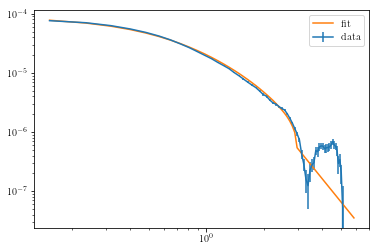

In [154]:
mplot.errorbar(R, data_vec, yerr=np.diag(data_file['cov'][:N, :N])**0.5, label='data')
#P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh = params
# mplot.loglog(R, P_sigma_gNFW_sh(1.3e-4, 1.0, 1.05, 4.5, 0.23, 3, 5, 0.4, R), label='random model')
P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh = result.x
mplot.loglog(R, P_sigma_gNFW_sh(P0, r_s, alpha, beta, gamma, r_sh, delta, Q_sh, R), label='fit')
mplot.legend()

0.0
0.0


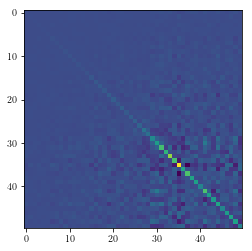

In [144]:
mplot.imshow(invcov)
print(np.linalg.det(data_file['cov'][:N, :N]))
new_cov = np.zeros((N,N))
for i in range(N):
    new_cov[i][i] = data_file['cov'][i, i]
print(np.linalg.det(new_cov))
